In [1]:
import paddle
import numpy as np
import matplotlib.pyplot as plt
import paddle.nn as nn
import os
import random
import numpy as np

print(paddle.__version__)  # 查看当前版本

/opt/conda/envs/python35-paddle120-env/lib/python3.7/site-packages/paddle/fluid/layers/utils.py:26: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  def convert_to_list(value, n, name, dtype=np.int):
/opt/conda/envs/python35-paddle120-env/lib/python3.7/site-packages/matplotlib/__init__.py:107: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated, and in 3.8 it will stop working
  from collections import MutableMapping
/opt/conda/envs/python35-paddle120-env/lib/python3.7/site-packages/matp

2.0.2


In [2]:
! unzip -oq /home/aistudio/data/data78806/语句分类.zip

In [3]:
data = open('语句分类/training_label.txt')
for i in data:
    print(i.split('+++$+++'))
    print(i.split(' ')[0])
    print(i.split('+++$+++')[-1].replace('\n', '').split(' '))
    break

['1 ', ' are wtf ... awww thanks !\n']
1
['', 'are', 'wtf', '...', 'awww', 'thanks', '!']


In [4]:
def open_label(data_path):  # 打开文件并读取数据
    '''
    这里数据读取适合与‘label’和‘nolabel’，因为data文件数据是标签 + 文本 读取出来的数据不正确
    '''
    dict_set = set()  # 新建一个集合（内容不可重复）
    with open(data_path, 'r', encoding='utf-8') as f:  # 读取数据到f
        for line in f.readlines():  # 逐行获取f的内容
            # print(1)
            title = line.split('+++$+++')[-1].replace('\n', '').split(' ')  # 此处效果查看上一个code
            for s in title[1:]:  # 循环内容
                dict_set.add(s)  # 数据存入集合
    # print(dict_set)
    print(f'{data_path}数据读取完毕')
    return dict_set

def open_data(data_path):  # 打开文件并读取数据
    dict_set = set()  # 新建一个集合（内容不可重复）
    with open(data_path, 'r', encoding='utf-8') as f:  # 读取数据到f
        for line in f.readlines():  # 逐行获取f的内容
            # print(1)
            title =  line.replace(',', ' ').replace('\n', '').split(' ')
            for s in title[1:]:  # 循环内容
                dict_set.add(s)  # 数据存入集合
    # print(dict_set)
    print(f'{data_path}数据读取完毕')
    return dict_set

def create_dict(label_path, nolabel_path, data_path, dict_path):
    '''
    把数据生成字典
    '''
    print('正在读取数据……')
    label_data = open_label(label_path)  # 读取数据
    nolabel_data = open_label(nolabel_path)
    data_data = open_data(data_path)
    dict_set = label_data | nolabel_data | data_data  # 使用并集获得数据
    print('正在生产字典……')
    dict_list = []  # 新建一个空列表
    i = 0
    for s in dict_set:  # 循环集合
        dict_list.append([s, i])  # 存入集合并新建一个单独对应的数值
        i += 1
    
    dict_txt = dict(dict_list)  # 强制转换成 字典
    end_dict = {"<unk>": i}  # 添加未知字符<unk>
    dict_txt.update(end_dict)  # 空字符数据存入
    # 把这些字典保存到本地中
    with open(dict_path, 'w', encoding='utf-8') as f:
        f.write(str(dict_txt))  # 把字典存入文本

    print("数据字典生成完成！")
    print(f'字典长度为：{len(dict_txt.keys())}')
    return dict_txt

label_path = '语句分类/training_label.txt'  # 把地址进行赋值
data_path = '语句分类/testing_data.txt'
nolabel_path = '语句分类/training_nolabel.txt'
dict_path = './dict.txt'

word_dict = create_dict(label_path, nolabel_path, data_path, dict_path)  

正在读取数据……
语句分类/training_label.txt数据读取完毕
语句分类/training_nolabel.txt数据读取完毕
语句分类/testing_data.txt数据读取完毕
正在生产字典……
数据字典生成完成！
字典长度为：245076


In [5]:
print(word_dict['deux'])  # 选择查看
print(word_dict['<unk>'])  # 选择查看

236001
245075


In [6]:
# 创建数据集和数据字典
with open('语句分类/training_label.txt', 'r', encoding='utf-8') as f_data:   # 读取文件
    data_list = []   # 新建列表
    for line in f_data.readlines():  # 逐行读取
        # print(line)
        title = line.split('+++$+++')[-1].replace('\n', '').split(' ')  # 获取文本数据列表
        l = line.split()[0]  # 获取标签 
        labs = ""
        for s in title[1:]:  # 循环得到数据
            lab = str(word_dict[s])  # 获取数据对应标签
            labs = labs + lab + ','  # 逐个添加数据并加上,
        labs = labs[:-1]  # 去掉最后一个,
        labs = labs + '\t' + l + '\n'  # 获得文本数据加上tab加上标签加上换行
        data_list.append(labs)  # 添加进数据
    random.shuffle(data_list)  # 打乱数据
    val_len = int(len(data_list)*0.8)  # 按照8:2进行切割
    val_data = data_list[val_len:]  # 后面20%
    train_data =  data_list[:val_len]  # 前面80%
    with open('./val.txt', 'w', encoding='utf-8') as f_val:
        f_val.write(str(val_data))  # 写入数据
    with open('./train.txt', 'w', encoding='utf-8') as f_train:
        f_train.write(str(train_data))

print("数据列表生成完成！")
print(f'训练集数据{len(train_data)}条')
print(f'验证集数据{len(val_data)}条')

数据列表生成完成！
训练集数据160000条
验证集数据40000条


In [7]:
vocab_size = len(word_dict) + 1  # 字典长度加一 备用
print(vocab_size)
seq_len = 35  # 数据集长度（需要扩充的长度）
batch_size = 32  # 批处理大小
epochs = 2  # 训练轮数
learning_rate=0.001  # 学习率
pad_id = word_dict['<unk>']  # 空的填充内容值

# 生成句子列表
def ids_to_str(ids):
    # print(ids)
    words = []
    for k in ids:  # 循环列表
        w = list(word_dict)[eval(k)]  # 获取对应索引的值 
        words.append(w if isinstance(w, str) else w.decode('ASCII'))  # 写入数据
    return " ".join(words)  # 返回拼接的数据

245077


In [8]:
for i in  train_data:  # 循环数据
    # i = i
    print(i)  # 输出原始数据
    sent = i[:-3].split(',')  # 数据处理
    label = int(i[-2])  # 获取标签
    print('sentence list id is:', sent)
    print('sentence label id is:', label)
    print('--------------------------')
    print('sentence list is: ', ids_to_str(sent))
    print('sentence label is: ', label)
    break

46510,241795,45718,165045,17476,20682,134406,76634,1237,134406,179599,161072,104683,76634,90191,134576,45718,140325,37103,18909,24419	0

sentence list id is: ['46510', '241795', '45718', '165045', '17476', '20682', '134406', '76634', '1237', '134406', '179599', '161072', '104683', '76634', '90191', '134576', '45718', '140325', '37103', '18909', '24419']
sentence label id is: 0
--------------------------
sentence list is:  think about the cog ' s and their families and friends who lost their lives in the air france crash .
sentence label is:  0


In [9]:
# 读取数据扩充并查看
def create_padded_dataset(dataset):
    padded_sents = []
    labels = []
    for batch_id, data in enumerate(dataset):  # 循环得到数据
        data = data.replace('\n', '').replace('\t', ',').split(',')  # 对数据做处理得到列表
        # print(data)
        sent, label = data[:-2], data[-1]  # 返回数字化文本及标签
        padded_sent = np.concatenate([sent[:seq_len], [pad_id] * (seq_len - len(sent))]).astype('int64')  # 数字化文本扩充
            
        # print(padded_sent)
        padded_sents.append(padded_sent)  # 添加到数字化文本列表
        labels.append(label)  # 添加到标签列表
    # print(padded_sents)
    return np.array(padded_sents), np.array(labels).astype('int64').reshape(len(labels),1)  # 返回数据

# 对train、val数据进行实例化
train_sents, train_labels = create_padded_dataset(train_data)
val_sents, val_labels = create_padded_dataset(val_data)
# 查看数据大小
print(train_sents.shape)
print(train_labels.shape)
print(val_sents.shape)
print(val_labels.shape)

(160000, 35)
(160000, 1)
(40000, 35)
(40000, 1)


In [10]:
for i in train_sents:  #  查看train数据
    print(i)
    break

[ 46510 241795  45718 165045  17476  20682 134406  76634   1237 134406
 179599 161072 104683  76634  90191 134576  45718 140325  37103  18909
 245075 245075 245075 245075 245075 245075 245075 245075 245075 245075
 245075 245075 245075 245075 245075]


In [11]:
# 继承paddle.io.Dataset对数据进行处理
class IMDBDataset(paddle.io.Dataset):
    '''
    继承paddle.io.Dataset类进行封装数据
    '''
    def __init__(self, sents, labels):
        # 数据读取
        self.sents = sents
        self.labels = labels
    
    def __getitem__(self, index):
        # 数据处理
        data = self.sents[index]
        label = self.labels[index]

        return data, label

    def __len__(self):
        # 返回大小数据
        return len(self.sents)

# 数据实例化 
train_dataset = IMDBDataset(train_sents, train_labels)
val_dataset = IMDBDataset(val_sents, val_labels)

# 封装成生成器
train_loader = paddle.io.DataLoader(train_dataset, return_list=True,
                                    shuffle=True, batch_size=128, drop_last=True)
val_loader = paddle.io.DataLoader(val_dataset, return_list=True,
                                    shuffle=True, batch_size=32, drop_last=True)

In [12]:
for i in train_dataset:  # 查看封装前的数据
    print(i)
    break

(array([ 46510, 241795,  45718, 165045,  17476,  20682, 134406,  76634,
         1237, 134406, 179599, 161072, 104683,  76634,  90191, 134576,
        45718, 140325,  37103,  18909, 245075, 245075, 245075, 245075,
       245075, 245075, 245075, 245075, 245075, 245075, 245075, 245075,
       245075, 245075, 245075]), array([0]))


In [13]:
for i in train_loader :  # 查看封装后的数据
    print(i)
    break

/opt/conda/envs/python35-paddle120-env/lib/python3.7/site-packages/paddle/fluid/dataloader/dataloader_iter.py:89: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  if isinstance(slot[0], (np.ndarray, np.bool, numbers.Number)):


[Tensor(shape=[128, 35], dtype=int64, place=CUDAPinnedPlace, stop_gradient=True,
       [[68310 , 144767, 243501, ..., 245075, 245075, 245075],
        [46288 , 99282 , 14220 , ..., 245075, 245075, 245075],
        [226234, 214230, 243501, ..., 245075, 245075, 245075],
        ...,
        [31345 , 214230, 65601 , ..., 245075, 245075, 245075],
        [124842, 212048, 97581 , ..., 245075, 245075, 245075],
        [107568, 81964 , 245075, ..., 245075, 245075, 245075]]), Tensor(shape=[128, 1], dtype=int64, place=CUDAPinnedPlace, stop_gradient=True,
       [[1],
        [0],
        [1],
        [0],
        [1],
        [1],
        [1],
        [1],
        [1],
        [0],
        [0],
        [0],
        [1],
        [1],
        [0],
        [1],
        [1],
        [1],
        [1],
        [1],
        [0],
        [0],
        [1],
        [0],
        [1],
        [1],
        [0],
        [1],
        [1],
        [1],
        [1],
        [0],
        [0],
        [1],
     

In [14]:
class MyRNN(paddle.nn.Layer):
    def __init__(self):
        super(MyRNN, self).__init__()
        self.embedding = nn.Embedding(vocab_size, 256)  # 嵌入层用于自动构造一个二维embedding矩阵
        self.rnn = nn.SimpleRNN(256, 256, num_layers=2, direction='forward',dropout=0.5)  # 使用简易的RNN模型
        self.linear = nn.Linear(in_features=256*2, out_features=2)  # 分类器
        self.dropout = nn.Dropout(0.5)  # 正则化
    
    def forward(self, inputs):
        emb = self.dropout(self.embedding(inputs))
        #output形状大小为[batch_size,seq_len,num_directions * hidden_size]
        #hidden形状大小为[num_layers * num_directions, batch_size, hidden_size]
        #把前向的hidden与后向的hidden合并在一起
        output, hidden = self.rnn(emb)
        hidden = paddle.concat((hidden[-2,:,:], hidden[-1,:,:]), axis = 1)
        #hidden形状大小为[batch_size, hidden_size * num_directions]
        hidden = self.dropout(hidden)
        return self.linear(hidden) 

In [15]:
# 可视化定义
def draw_process(title,color,iters,data,label):
    plt.title(title, fontsize=24)  # 标题
    plt.xlabel("iter", fontsize=20)  # x轴
    plt.ylabel(label, fontsize=20)  # y轴
    plt.plot(iters, data,color=color,label=label)   # 画图
    plt.legend()
    plt.grid()
    plt.show()

W0609 16:42:58.710011   242 device_context.cc:362] Please NOTE: device: 0, GPU Compute Capability: 7.0, Driver API Version: 12.0, Runtime API Version: 10.1
W0609 16:42:58.715515   242 device_context.cc:372] device: 0, cuDNN Version: 7.6.


epoch: 0, batch_id: 0, loss is: [0.6817595]
epoch: 0, batch_id: 500, loss is: [0.6942775]
epoch: 0, batch_id: 1000, loss is: [0.6956935]
[validation] accuracy: 0.4978249967098236, loss: 0.6935177445411682
epoch: 1, batch_id: 0, loss is: [0.69561636]
epoch: 1, batch_id: 500, loss is: [0.6925569]
epoch: 1, batch_id: 1000, loss is: [0.70219636]
[validation] accuracy: 0.5461500287055969, loss: 0.6882537603378296
epoch: 2, batch_id: 0, loss is: [0.6846287]
epoch: 2, batch_id: 500, loss is: [0.69569755]
epoch: 2, batch_id: 1000, loss is: [0.69609284]
[validation] accuracy: 0.5250499844551086, loss: 0.6963083744049072
epoch: 3, batch_id: 0, loss is: [0.6881584]
epoch: 3, batch_id: 500, loss is: [0.73849404]
epoch: 3, batch_id: 1000, loss is: [0.6810992]
[validation] accuracy: 0.5385749936103821, loss: 0.6894043684005737
epoch: 4, batch_id: 0, loss is: [0.6904796]
epoch: 4, batch_id: 500, loss is: [0.6980019]
epoch: 4, batch_id: 1000, loss is: [0.68666315]
[validation] accuracy: 0.530300021171

/opt/conda/envs/python35-paddle120-env/lib/python3.7/site-packages/matplotlib/cbook/__init__.py:2349: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated, and in 3.8 it will stop working
  if isinstance(obj, collections.Iterator):
/opt/conda/envs/python35-paddle120-env/lib/python3.7/site-packages/matplotlib/cbook/__init__.py:2366: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated, and in 3.8 it will stop working
  return list(data) if isinstance(data, collections.MappingView) else data


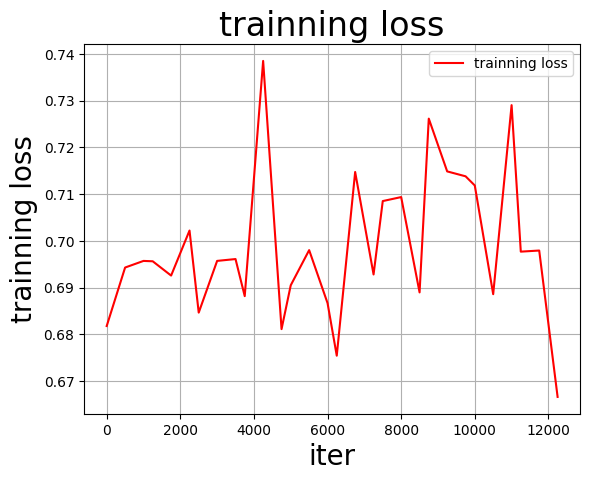

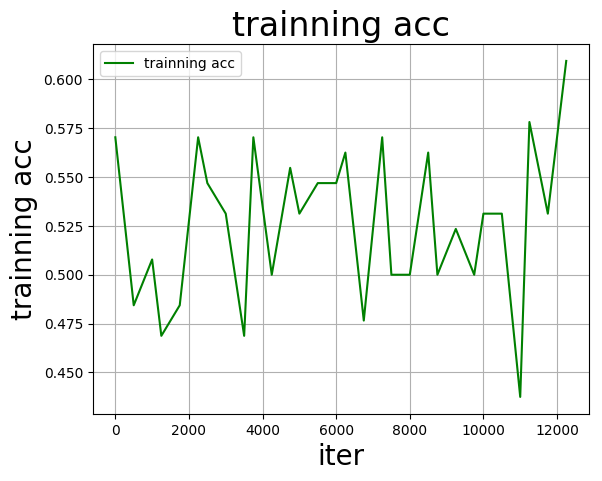

In [16]:
# 训练模型
def train(model):
    model.train()
    opt = paddle.optimizer.Adam(learning_rate=learning_rate, parameters=model.parameters())  # 优化器学习率等
    # 初始值设置
    steps = 0
    Iters, total_loss, total_acc = [], [], []

    epochs = 2
    for epoch in range(epochs):  # 训练循环
        for batch_id, data in enumerate(train_loader):  # 数据循环
            steps += 1
            sent = data[0]  # 获取数据
            label = data[1]  # 获取标签
            
            logits = model(sent)  # 输入数据
            loss = paddle.nn.functional.cross_entropy(logits, label)  # loss获取
            acc = paddle.metric.accuracy(logits, label)  # acc获取

            if batch_id % 500 == 0:  # 每500次输出一次结果
                Iters.append(steps)  # 保存训练轮数
                total_loss.append(loss.numpy()[0])  # 保存loss
                total_acc.append(acc.numpy()[0])  # 保存acc

                print("epoch: {}, batch_id: {}, loss is: {}".format(epoch, batch_id, loss.numpy()))  # 输出结果
            
            # 数据更新
            loss.backward()  
            opt.step()  
            opt.clear_grad()  

        # 每一个epochs进行一次评估
        model.eval()
        accuracies = []
        losses = []
        
        for batch_id, data in enumerate(val_loader):  # 数据循环读取
            
            sent = data[0]  # 训练内容读取
            label = data[1]  # 标签读取

            logits = model(sent)  # 训练数据
            loss = paddle.nn.functional.cross_entropy(logits, label)  # loss获取
            acc = paddle.metric.accuracy(logits, label)  # acc获取
            
            accuracies.append(acc.numpy())  # 添加数据
            losses.append(loss.numpy())  
        
        avg_acc, avg_loss = np.mean(accuracies), np.mean(losses)  # 获取loss、acc平均值
        print("[validation] accuracy: {}, loss: {}".format(avg_acc, avg_loss))  # 输出值
        
        model.train()
    
        paddle.save(model.state_dict(),str(epoch)+"_model_final.pdparams")  # 保存训练文件
    
    draw_process("trainning loss","red",Iters,total_loss,"trainning loss")  # 画处loss图
    draw_process("trainning acc","green",Iters,total_acc,"trainning acc")  # 画出caa图
        
model = MyRNN()  # 模型实例化
train(model)  # 开始训练

In [17]:
'''
模型评估
'''
model_state_dict = paddle.load('1_model_final.pdparams')  # 导入模型
model = MyRNN()  # 网络实例化
model.set_state_dict(model_state_dict) 
model.eval()
accuracies = []
losses = []

for batch_id, data in enumerate(val_loader):  # 循环val数据
    
    sent = data[0]  # 获得数据
    label = data[1]  # 获得标签

    logits = model(sent)  # 进行预测
    loss = paddle.nn.functional.cross_entropy(logits, label)  # 获得loss
    acc = paddle.metric.accuracy(logits, label)  # 获得acc
    
    accuracies.append(acc.numpy())  # 保存loss
    losses.append(loss.numpy())  # 保存acc

avg_acc, avg_loss = np.mean(accuracies), np.mean(losses)  # 获取loss和acc均值
print("[validation] accuracy: {}, loss: {}".format(avg_acc, avg_loss))

[validation] accuracy: 0.5461500287055969, loss: 0.6882537007331848
